## Import necessary libraries & Data Preprocessed

In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.colorbar as colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from math import ceil
from collections import Counter
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering,MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")


In [3]:
# import data preprocessed
df_preprocessed = pd.read_csv("data_preprocessed.csv")
df_preprocessed.head(2)

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_afternoon,HR_evening,Weekdays,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,2,0.0,0,2,28.88,2,14.440,0.5,CUI_Indian,Asian_Cuisine
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0.0,0,2,19.21,2,9.605,1.0,CUI_American,Western_Cuisine


In [4]:
df_preprocessed.drop(columns="customer_id", inplace=True) # it´s easier to have customers id as 0,1,2 for clusters.
df_preprocessed.head(1)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,HR_afternoon,HR_evening,Weekdays,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type
0,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.0,...,2,0.0,0,2,28.88,2,14.44,0.5,CUI_Indian,Asian_Cuisine


## RFM Analysis (Standby for now)

In [6]:
df_rfm = df[["last_order", "total_orders", "total_spent"]].copy()

In [7]:
# Create a new column 'date_of_last_order' by adding the number of days in 'last_order' to January 1st, 2024
#df_rfm['date_of_last_order'] = pd.to_datetime('01-01-2024') + pd.to_timedelta(df_rfm['last_order'], unit='D')
#df_rfm

In [8]:
df_rfm = df_rfm.rename(columns={"last_order": "recency", "total_orders": "frequency", "total_spent": "monetary"})

In [9]:
df_rfm['recency'] = 90 - df_rfm['recency']
df_rfm

,recency,frequency,monetary
0,89,2,28.88
1,89,2,19.21
2,89,2,9.20
3,88,2,31.56
4,88,2,55.44
...,...,...,...
31712,90,1,18.04
31713,90,1,18.04
31714,90,1,17.79
31715,90,1,12.03


In [10]:
df_rfm['R_rank'] = df_rfm['recency'].rank(ascending=False)
df_rfm['F_rank'] = df_rfm['frequency'].rank(ascending=True)
df_rfm['M_rank'] = df_rfm['monetary'].rank(ascending=True)

# normalizing the rank of the customers
df_rfm['R_rank_norm'] = (df_rfm['R_rank'] / df_rfm['R_rank'].max()) * 100
df_rfm['F_rank_norm'] = (df_rfm['F_rank'] / df_rfm['F_rank'].max()) * 100
df_rfm['M_rank_norm'] = (df_rfm['M_rank'] / df_rfm['M_rank'].max()) * 100

df_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

df_rfm.head()

,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,89,2,28.88,0.419539,33.147839,57.286313
1,89,2,19.21,0.419539,33.147839,41.231832
2,89,2,9.20,0.419539,33.147839,15.602043
3,88,2,31.56,0.602495,33.147839,62.178012
4,88,2,55.44,0.602495,33.147839,80.728001


In [11]:
df_rfm['RFM_Score'] = 0.15*df_rfm['R_rank_norm']+0.28 *	df_rfm['F_rank_norm']+0.57*df_rfm['M_rank_norm']
df_rfm['RFM_Score'] *= 0.05
rfm_df = df_rfm.round(2)
rfm_df[['RFM_Score']].head(7)


,RFM_Score
0,2.10
1,1.64
2,0.91
3,2.24
4,2.77
5,1.96
6,0.79


In [12]:
df_rfm["Customer_segment"] = np.where(df_rfm['RFM_Score'] > 4.5, "Top Customers", 
                                    np.where(df_rfm['RFM_Score'] > 4,
                                        "High value Customer",
                                        np.where(df_rfm['RFM_Score'] > 3,"Medium Value Customer",
                            np.where(df_rfm['RFM_Score'] > 1.6, 
                            'Low Value Customers', 'Lost Customers'))))

df_rfm[['RFM_Score', 'Customer_segment']].head(20)


,RFM_Score,Customer_segment
0,2.099876,Low Value Customers
1,1.642323,Low Value Customers
2,0.911875,Lost Customers
3,2.240662,Low Value Customers
4,2.769336,Low Value Customers
5,1.961071,Low Value Customers
6,0.792299,Lost Customers
7,2.360846,Low Value Customers
8,1.541930,Lost Customers
9,2.274198,Low Value Customers


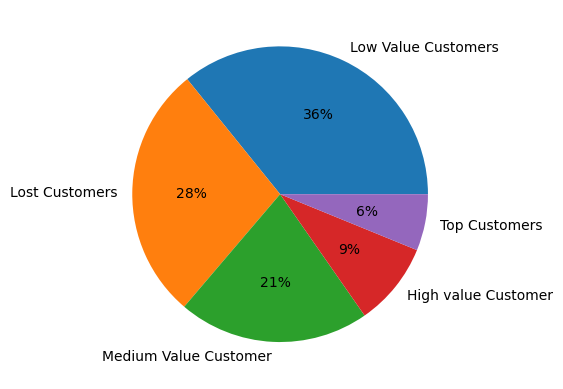

In [13]:
plt.pie(df_rfm.Customer_segment.value_counts(),
        labels=df_rfm.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [14]:
df_rfm["Customer_segment"].value_counts()

Customer_segment
Low Value Customers      11359
Lost Customers            8866
Medium Value Customer     6634
High value Customer       2900
Top Customers             1958
Name: count, dtype: int64

In [15]:
# Create a copy of df_rfm
df_rfm2 = df_rfm[['recency', 'frequency', 'monetary']].copy()

# Divide recency into 5 quintiles
df_rfm2['recency_quintile'] = pd.qcut(df_rfm2['recency'], 5, labels=False, duplicates='drop') + 1

# Divide frequency into 5 quintiles
df_rfm2['frequency_quintile'] = pd.qcut(df_rfm2['frequency'], 5, labels=False, duplicates='drop') + 1

# Divide monetary into 5 quintiles
df_rfm2['monetary_quintile'] = pd.qcut(df_rfm2['monetary'], 5, labels=False, duplicates='drop') + 1

# Display the first few rows of the updated dataframe
df_rfm2.head()

,recency,frequency,monetary,recency_quintile,frequency_quintile,monetary_quintile
0,89,2,28.88,5,1,3
1,89,2,19.21,5,1,3
2,89,2,9.20,5,1,1
3,88,2,31.56,5,1,4
4,88,2,55.44,5,1,5


In [16]:
# Create the RFM_score column
df_rfm2['RFM_score'] = df_rfm2['recency_quintile'].astype(str) + df_rfm2['frequency_quintile'].astype(str) + df_rfm2['monetary_quintile'].astype(str)

df_rfm2

,recency,frequency,monetary,recency_quintile,frequency_quintile,monetary_quintile,RFM_score
0,89,2,28.88,5,1,3,513
1,89,2,19.21,5,1,3,513
2,89,2,9.20,5,1,1,511
3,88,2,31.56,5,1,4,514
4,88,2,55.44,5,1,5,515
...,...,...,...,...,...,...,...
31712,90,1,18.04,5,1,2,512
31713,90,1,18.04,5,1,2,512
31714,90,1,17.79,5,1,2,512
31715,90,1,12.03,5,1,2,512


In [17]:
def assign_segment(r, f, m):
    if r == 5 and f == 5 and m == 5:
        return "Best Customers"
    elif r >= 4 and f >= 4 and m >= 4:
        return "Loyal Champions"
    elif r <= 2 and f >= 4 and m >= 4:
        return "At-Risk Big Spenders"
    elif r >= 4 and f >= 3:
        return "Potential Loyalists"
    elif r <= 2 and f <= 2:
        return "Churned Customers"
    elif f >= 4 and m >= 4:
        return "Frequent Big Spenders"
    elif r >= 3 and m >= 4:
        return "High Potential"
    else:
        return "Other"

# Apply the segmentation function
df_rfm2["Segment"] = df_rfm2.apply(
    lambda row: assign_segment(row["recency_quintile"], row["frequency_quintile"], row["monetary_quintile"]),
    axis=1,
)

df_rfm2

,recency,frequency,monetary,recency_quintile,frequency_quintile,monetary_quintile,RFM_score,Segment
0,89,2,28.88,5,1,3,513,Other
1,89,2,19.21,5,1,3,513,Other
2,89,2,9.20,5,1,1,511,Other
3,88,2,31.56,5,1,4,514,High Potential
4,88,2,55.44,5,1,5,515,High Potential
...,...,...,...,...,...,...,...,...
31712,90,1,18.04,5,1,2,512,Other
31713,90,1,18.04,5,1,2,512,Other
31714,90,1,17.79,5,1,2,512,Other
31715,90,1,12.03,5,1,2,512,Other


In [18]:
df_rfm2["Segment"].value_counts()

Segment
Other                    16455
Churned Customers         4905
At-Risk Big Spenders      3992
High Potential            3509
Potential Loyalists       1743
Frequent Big Spenders      749
Loyal Champions            364
Name: count, dtype: int64

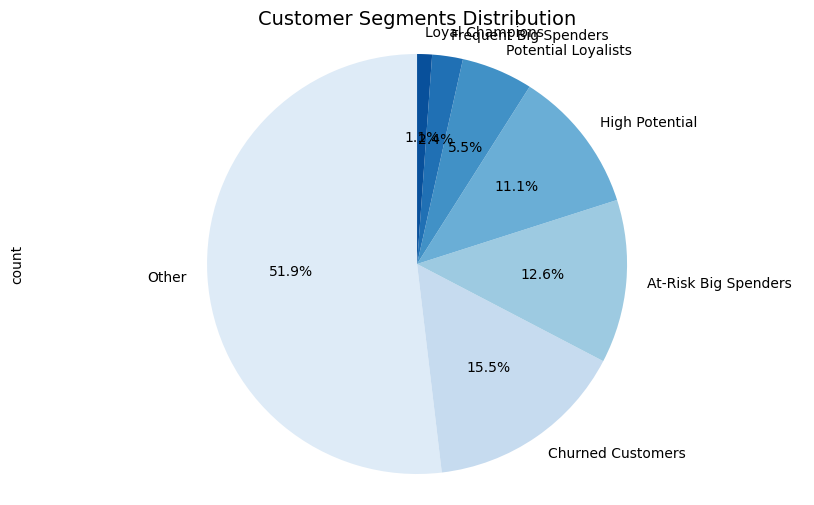

In [19]:
# Create a pie chart for the 'Segment' column in df_rfm2
plt.figure(figsize=(10, 6))
df_rfm2["Segment"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Blues", df_rfm2["Segment"].nunique()))

# Add a title
plt.title('Customer Segments Distribution', fontsize=14)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

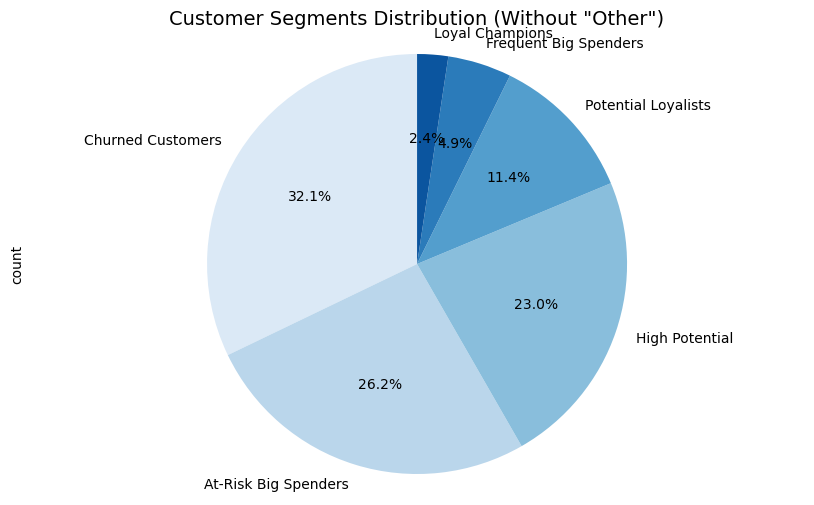

In [20]:
# Filter out the 'Other' segment
filtered_rfm2 = df_rfm2[df_rfm2["Segment"] != "Other"]

# Create a pie chart for the 'Segment' column in filtered_rfm2
plt.figure(figsize=(10, 6))
filtered_rfm2["Segment"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Blues", filtered_rfm2["Segment"].nunique()))

# Add a title
plt.title('Customer Segments Distribution (Without "Other")', fontsize=14)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

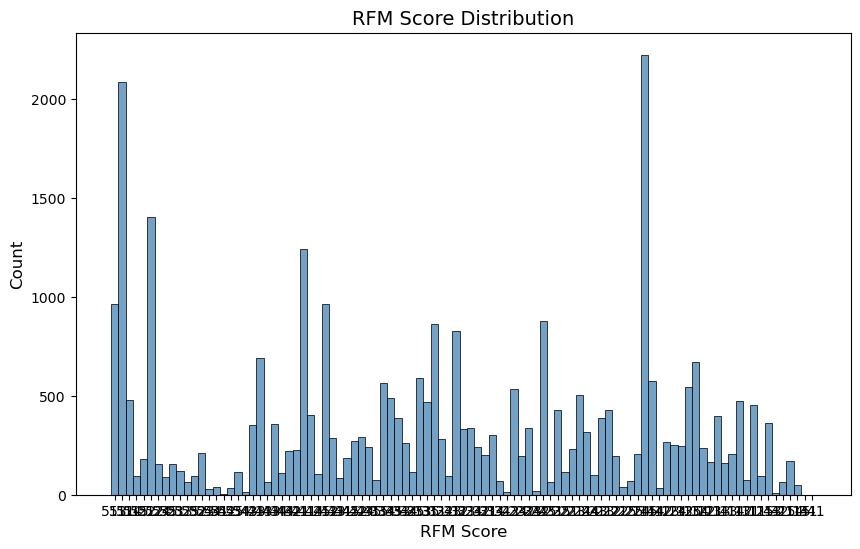

In [21]:
# Create a rollout plot for df_rfm2
plt.figure(figsize=(10, 6))
sns.histplot(df_rfm2['RFM_score'], kde=False, color='#4682B4', bins=15)

# Add a title and labels
plt.title('RFM Score Distribution', fontsize=14)
plt.xlabel('RFM Score', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

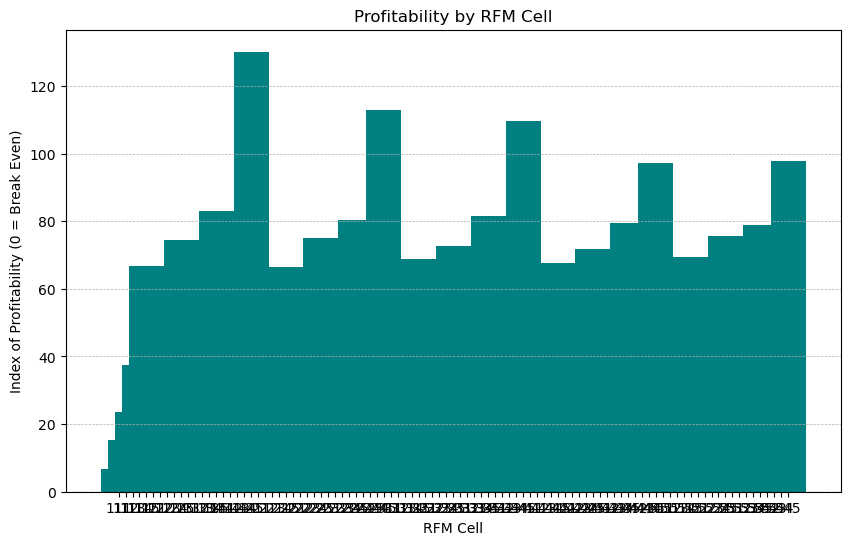

In [22]:
rfm_cells = df_rfm2['RFM_score'].unique()
profitability_index = df_rfm2.groupby('RFM_score')['monetary'].mean()

# Sort the values for better visualization
profitability_index = profitability_index.sort_index()
rfm_cells = profitability_index.index
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(rfm_cells, profitability_index, color='teal', width=5)

# Adding a horizontal line at y=0 for breakeven
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Labels and title
plt.xlabel("RFM Cell")
plt.ylabel("Index of Profitability (0 = Break Even)")
plt.title("Profitability by RFM Cell")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


In [23]:
df_rfm3 = df_rfm2.copy()
df_rfm3.drop(columns=['Segment'], inplace=True)
df_rfm3

,recency,frequency,monetary,recency_quintile,frequency_quintile,monetary_quintile,RFM_score
0,89,2,28.88,5,1,3,513
1,89,2,19.21,5,1,3,513
2,89,2,9.20,5,1,1,511
3,88,2,31.56,5,1,4,514
4,88,2,55.44,5,1,5,515
...,...,...,...,...,...,...,...
31712,90,1,18.04,5,1,2,512
31713,90,1,18.04,5,1,2,512
31714,90,1,17.79,5,1,2,512
31715,90,1,12.03,5,1,2,512


In [24]:
rfm_coordinates = {"Champions": [3, 5, 4, 5],
                   "Loyal Customers": [3, 5, 2, 4],
                   "Cannot lose them": [4, 5, 0, 2],
                   "At-Risk": [2, 4, 0, 2],
                   "Hibernating": [0, 2, 0, 2],
                   "About To Sleep": [0, 2, 2, 3],
                   "Promising": [0, 1, 3, 4],
                   "New Customers": [0, 1, 4, 5],
                   "Potential Loyalists": [1, 3, 3, 5],
                   "Need Attention": [2, 3, 2, 3]}

def assign_segment(r, f, m):
    for segment, (f_min, f_max, r_min, r_max) in rfm_coordinates.items():
        if f_min < f <= f_max and r_min < r <= r_max:
            return segment
    return "Other"

# Apply the segmentation function
df_rfm3["Segment"] = df_rfm3.apply(
    lambda row: assign_segment(row["recency_quintile"], row["frequency_quintile"], row["monetary_quintile"]),
    axis=1,
)

df_rfm3

,recency,frequency,monetary,recency_quintile,frequency_quintile,monetary_quintile,RFM_score,Segment
0,89,2,28.88,5,1,3,513,New Customers
1,89,2,19.21,5,1,3,513,New Customers
2,89,2,9.20,5,1,1,511,New Customers
3,88,2,31.56,5,1,4,514,New Customers
4,88,2,55.44,5,1,5,515,New Customers
...,...,...,...,...,...,...,...,...
31712,90,1,18.04,5,1,2,512,New Customers
31713,90,1,18.04,5,1,2,512,New Customers
31714,90,1,17.79,5,1,2,512,New Customers
31715,90,1,12.03,5,1,2,512,New Customers


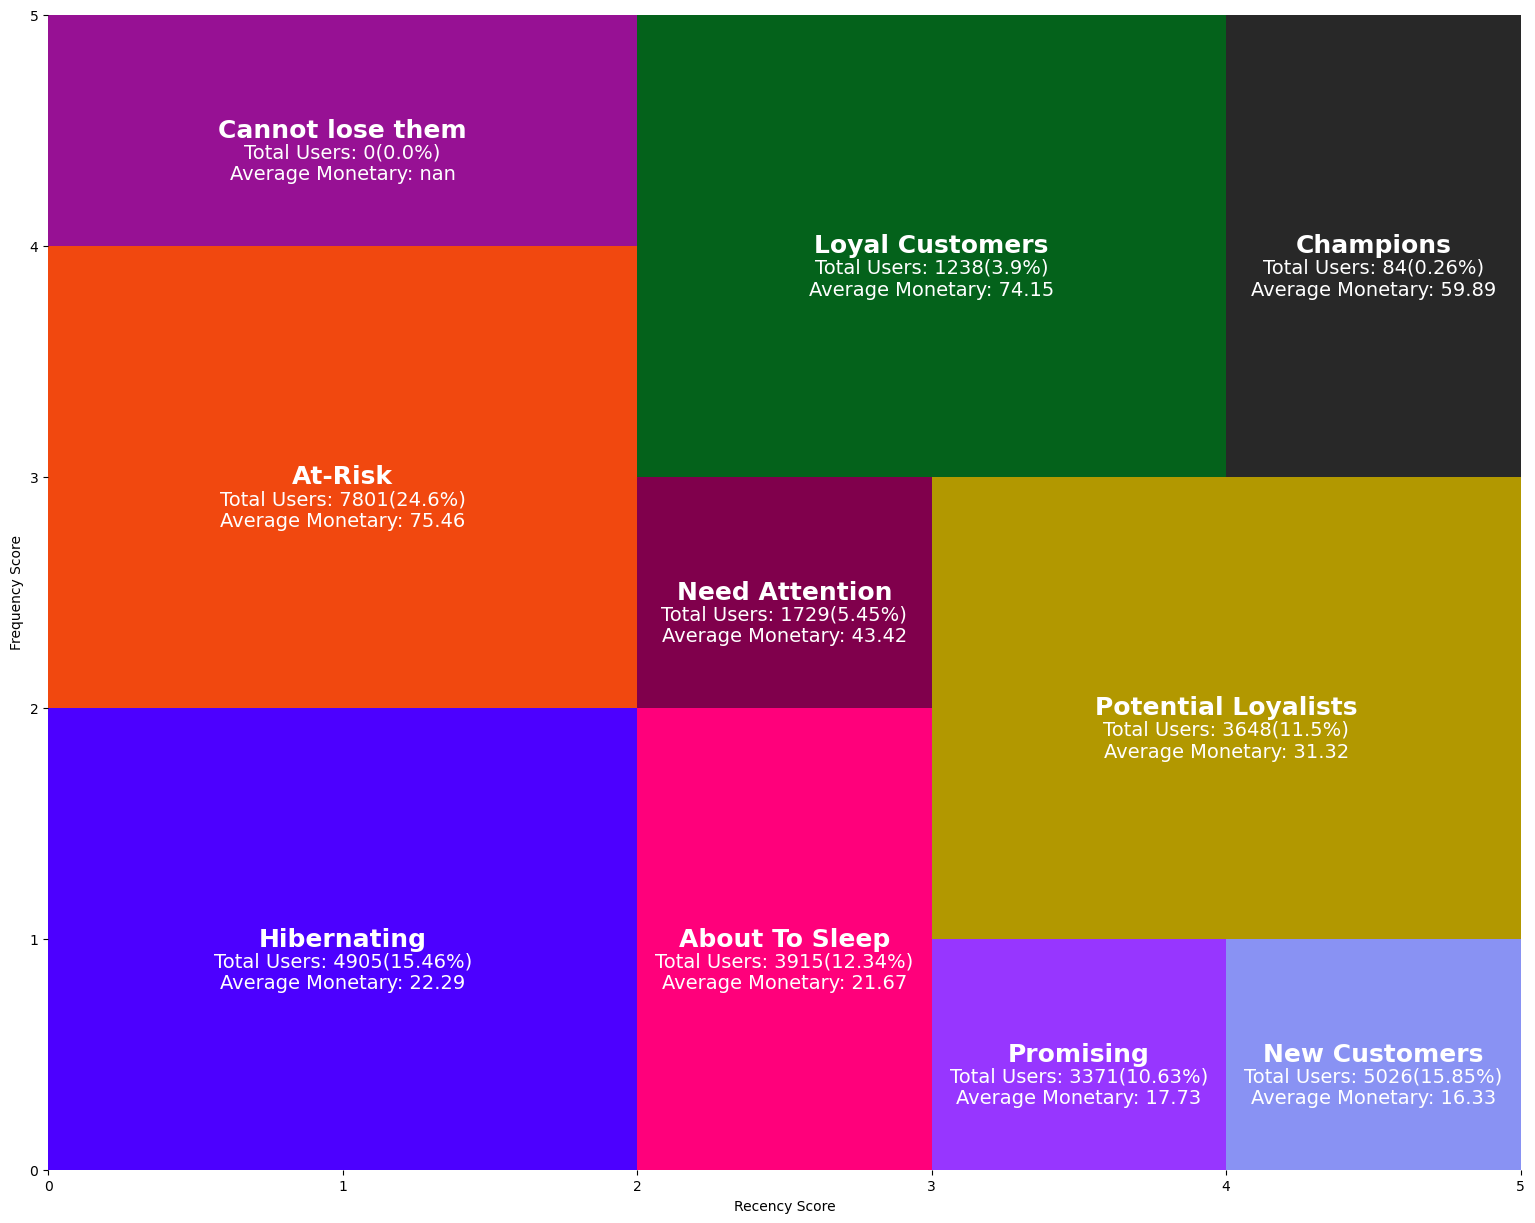

In [25]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

df_rfm2['Segment'] = df_rfm3.apply(
            lambda row: assign_segment(row['recency_quintile'], row['frequency_quintile'], row['monetary_quintile']),
            axis=1
        )
for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = df_rfm2[df_rfm3['Segment'] == key].shape[0]
    users_percentage = (df_rfm2[df_rfm3['Segment'] == key].shape[0] / df_rfm3.shape[0]) * 100
    avg_monetary = df_rfm2[df_rfm3['Segment'] == key]["monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

In [26]:
df_rfm3["Segment"].value_counts()

Segment
At-Risk                7801
New Customers          5026
Hibernating            4905
About To Sleep         3915
Potential Loyalists    3648
Promising              3371
Need Attention         1729
Loyal Customers        1238
Champions                84
Name: count, dtype: int64

In [27]:
print(df.columns.tolist())
df.head()


['customer_id', 'customer_region', 'customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category', 'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine', 'Other_Cuisines', 'chain_frequency', 'HR_morning', 'HR_lunch', 'HR_dinner', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent', 'total_orders', 'avg_spending_per_order', 'chain_order_ratio', 'preferred_cui_type']


,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_lunch,HR_dinner,HR_evening,Weekdays,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui_type
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,2,0,0.0,0,2,28.88,2,14.440,0.5,Asian_Cuisine
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0.0,0,2,19.21,2,9.605,1.0,Western_Cuisine
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,0,0,0.0,0,2,9.20,2,4.600,1.0,Western_Cuisine
3,180c632ed8,4660,26.0,2,3,1,0.0,2,DELIVERY,DIGI,...,1,0,0.0,1,1,31.56,2,15.780,0.5,Asian_Cuisine
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,...,0,0,0.0,1,1,55.44,2,27.720,0.0,Asian_Cuisine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712,f4e366c281,8670,30.0,1,1,1,0.0,0,FREEBIE,DIGI,...,0,0,0.0,0,1,18.04,1,18.040,1.0,Complementary_Cuisine
31713,f6b6709018,8670,26.0,1,1,0,0.0,0,DELIVERY,DIGI,...,1,0,0.0,0,1,18.04,1,18.040,0.0,Western_Cuisine
31714,f74ad8ce3f,8670,24.0,1,1,1,0.0,0,-,DIGI,...,0,0,1.0,0,1,17.79,1,17.790,1.0,Complementary_Cuisine
31715,f7b19c0241,8670,34.0,1,1,0,0.0,0,DISCOUNT,DIGI,...,0,0,0.0,0,1,12.03,1,12.030,0.0,Asian_Cuisine


## Kmeans and HG different perspectives:

### Scale Data and define some functions and perspetives:

In [5]:
df_preprocessed.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [ ]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
behaviour_features = ['Weekend','Weekdays', 'chain_order_ratio', 'HR_breakfast', 'HR_lunch_dinner', 'HR_afternoon', 'HR_evening']
preference_features = ['Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine', 'Other_Cuisines']

**After having final clusters we will associate categorical variables to each cluster (customer region, age_category, payment_method)**

In [151]:
metric_features = value_perspetive + behaviour_features + preference_features

In [6]:
# copy of preprocessed to df (scaled one)
df = df_preprocessed.copy()

# List of columns to exclude from scaling
exclude_columns = ["customer_region", "last_promo", "payment_method", "age_category", "chain_frequency", "preferred_cui_type", "preferred_cui"]

# Determine the columns to scale by excluding the specified columns
columns_to_scale = [col for col in df_preprocessed.columns if col not in exclude_columns]

# Instantiate the StandardScaler, fit and transform
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(df[columns_to_scale])

# Update the df with the scaled values
df[columns_to_scale] = ss_scaled_feat

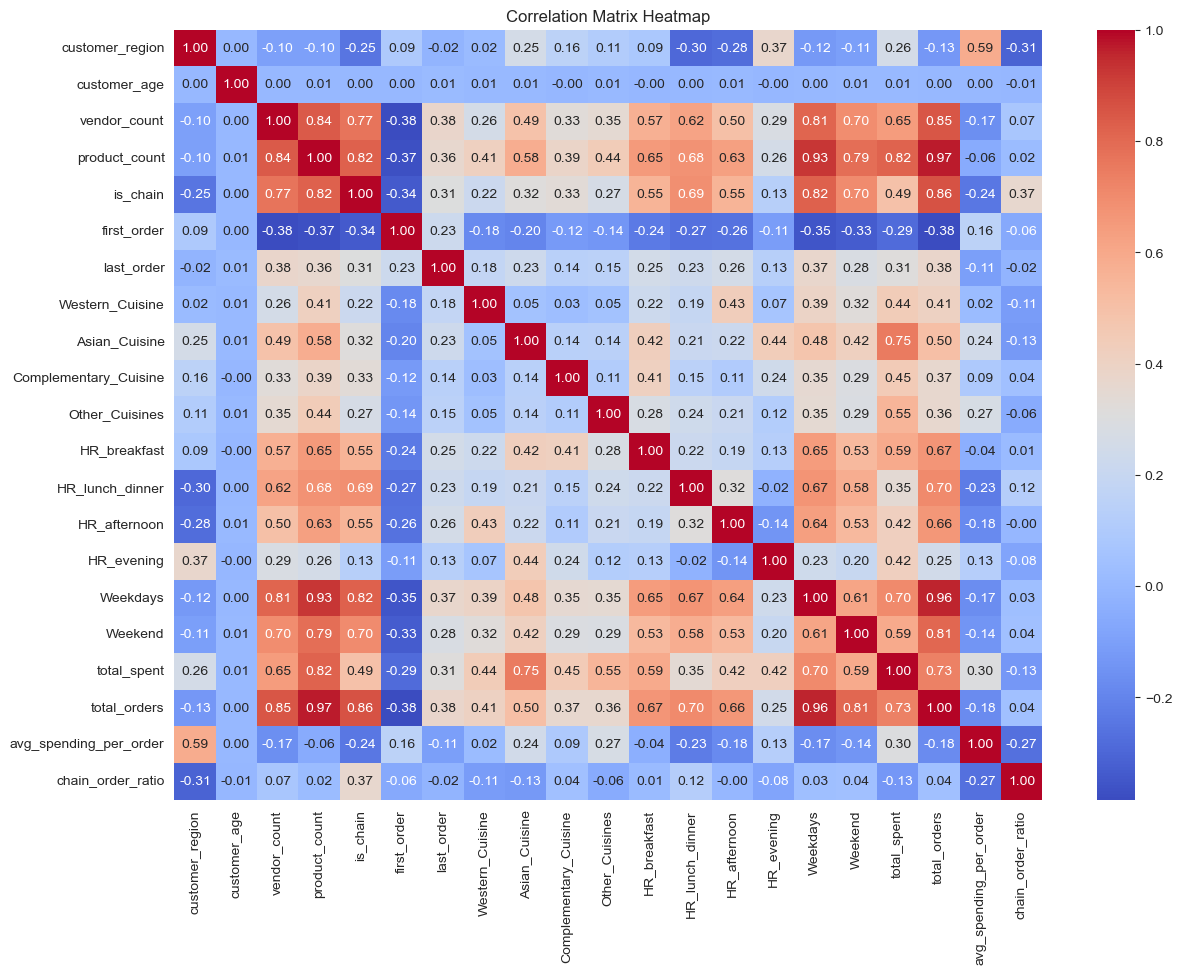

In [7]:
# Define the columns to exclude from the correlation calculation
exclude_columns = ['last_promo', 'payment_method', 'age_category', 'chain_frequency', 'preferred_cui_type', 'preferred_cui',
                   "HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8", "HR_9", "HR_10",
                   "HR_11", "HR_12", "HR_13", "HR_14", "HR_15", "HR_16", "HR_17", "HR_18", "HR_19", "HR_20",
                   "HR_21", "HR_22", "HR_23", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday",
                   "CUI_American", "CUI_Asian", "CUI_Cafe", "CUI_Beverages", "CUI_Chicken Dishes", "CUI_Chinese", "CUI_Desserts",
                    "CUI_Healthy","CUI_Indian","CUI_Italian","CUI_Japanese","CUI_Noodle Dishes","CUI_OTHER","CUI_Street Food / Snacks","CUI_Thai"]


# Drop the columns to exclude
df_filtered = df.drop(columns=exclude_columns)

# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Assess the correlations 


### Functions:

In [8]:


# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

# Hierarchical Clustering
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, metric="euclidean"):
    sst = get_sst(df)
    
    r2 = []  
    for i in range(min_nclus, max_nclus+1):
        cluster = AgglomerativeClustering(n_clusters=i, metric=metric, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = df.copy()
        df_concat['labels'] = hclabels
        r2.append(get_r2_score(df_concat, 'labels'))
        
    return np.array(r2)

def hierarchical_clustering_methods_nclust_analysis(dataframe, hc_methods, max_nclus, metric="euclidean"):
    r2_hc_methods = np.vstack(
        [
            get_r2_hc(dataframe, link, max_nclus, metric=metric)
            for link in hc_methods
        ]
    ).T

    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)
    plt.show()

# Plot dendrogram
def plot_dendrogram(dataframe, y_threshold, linkage="ward", metric='euclidean'):
    hclust = AgglomerativeClustering(linkage=linkage, metric=metric, distance_threshold=0, n_clusters=None)
    hclust.fit(dataframe)

    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    for i, merge in enumerate(hclust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, plt.gca().get_xlim()[1], colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage} | Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{metric} Distance', fontsize=13)
    plt.show()

# K-Means
def plot_inertia_silhouette_scores(dataframe, min_clust, max_clust):
    range_clusters = range(min_clust, max_clust + 1)

    inertia = []
    avg_silhouette = []
    for n_clus in range_clusters:
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(dataframe)
        inertia.append(kmclust.inertia_)
        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        avg_silhouette.append(silhouette_avg)

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 8)
    
    ax1.plot(range_clusters, inertia, marker='o')
    ax1.set_title('Inertia plot over clusters')
    ax1.set_ylabel("Inertia: SSw")
    ax1.set_xlabel("Number of clusters")
    ax1.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    ax2.plot(range_clusters, avg_silhouette, marker='o')
    ax2.set_title('Average silhouette plot over clusters')
    ax2.set_ylabel("Average silhouette")
    ax2.set_xlabel("Number of clusters")
    ax2.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    plt.show()

# Comparison of R2 scores
def plot_models_r2_nclust(models_dict, lower_lim):
    scores = []
    n_clusters = []
    for modelName, modelDataframe in models_dict.items():
        scores.append(get_r2_score(modelDataframe, 'labels'))
        n_clusters.append(len(np.unique(modelDataframe['labels'])))
        
    sns.set()
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 12.5)
    
    x = np.arange(len(scores))  # the label locations
    
    width = 0.20  # the width of the bars
    ax1.set_facecolor("white")
    ax1.bar(x - width/2, scores, width, color="#4A7A89")
    ax1.set_ylim(lower_lim, 1.0)
    ax1.set_ylabel('Scores', fontsize=14)
    ax1.set_title('R-Squared score by Model', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_dict.keys(), fontsize=14)
    
    ax2.set_facecolor("white")
    ax2.bar(x - width/2, n_clusters, width, color="#4A7A89")
    ax2.set_ylabel('Number of Clusters', fontsize=14)
    ax2.set_title('Number of Clusters by Model', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_dict.keys(), fontsize=14)
    plt.show()

# Cluster visualization
def plot_2dClusters(df_reduced, models_dict): 
    f, ax = plt.subplots(2, 3, sharey=True)
    f.set_size_inches(18.5, 12.5)
    xlabel = df_reduced.columns[0]
    ylabel = df_reduced.columns[1]
    j = 0
    i = 0
    for modelName, modelDataframe in models_dict.items():
        labels = modelDataframe['labels']
        if j == 3:
            i += 1
            j = 0
        ax[i][j].set_title(modelName, fontsize=15)
        ax[i][j].set_xlabel(xlabel, fontsize=15)
        ax[i][j].set_ylabel(ylabel, fontsize=15)
        ax[i][j].scatter(df_reduced.iloc[:, 0], df_reduced.iloc[:, 1], c=labels, cmap='tab20', s=2)
        j += 1
    plt.show()

# Access feature importance and reclassifying outliers
def get_ss_var(df):
    ss = df.var() * (df.count() - 1)
    return ss  # return sum of sum of squares of each df variable.

def get_r2_variables(df, labels_name):
    df_temp = df.copy()
    df_temp.drop(labels_name, axis=1, inplace=True)
    
    sst = get_ss_var(df_temp)
    ssw_labels = np.sum(df.groupby(labels_name).apply(get_ss_var))
    return 1 - ssw_labels / sst


### Value / RFM perspective

In [166]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
df_value = df[value_perspetive].copy()

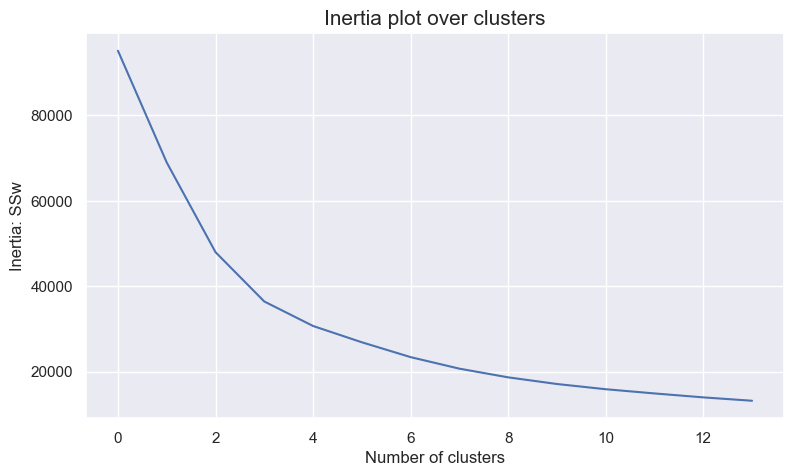

In [167]:
#check optimal number of clusters to keep with an elbow plot

range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_value)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [168]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_value) #performs clustering ie finds centroids

KMeans(n_clusters=3, n_init=15, random_state=15)

In [169]:
#location of each point
dist_matrix = pd.DataFrame(kmclust.transform(df_value)) #calculates distance of each sample to respective centroid

In [170]:
km_labels = kmclust.predict(df_value) #associates/predicts cluster index for each sample, based on min distance

In [171]:
# Characterizing the final clusters
df_concat = pd.concat([df_value, pd.Series(km_labels, name='value_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('value_labels').mean()

# Interpretation of the content of each cluster
df_centroids

,total_spent,avg_spending_per_order,last_order
value_labels,,,
0,-0.439017,0.048792,-1.377175
1,-0.198965,-0.341294,0.517751
2,1.648345,1.299887,0.510636


In [172]:
pd.DataFrame(km_labels)[0].value_counts()

0
1    18528
0     8649
2     4540
Name: count, dtype: int64

In [173]:
df['value_labels'] = df_concat['value_labels'] # adds labels to scale df

In [174]:
df['value_labels'].value_counts()

value_labels
1    18528
0     8649
2     4540
Name: count, dtype: int64

In [175]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_value) # get total sum of squares
ssw_labels = df_concat.groupby(['value_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.495


In [176]:
silhoutte_score = silhouette_score(df_value, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.394


In [177]:
calinski_harabasz = calinski_harabasz_score(df_value, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  15569.437


This high result indicates that results are well distributed.

### Preferences Perspective

In [121]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [23]:
preference_features = [
    'Western_Cuisine',
    'Asian_Cuisine',
    'Complementary_Cuisine',
    'Other_Cuisines'
]

df_prf = df[preference_features].copy()

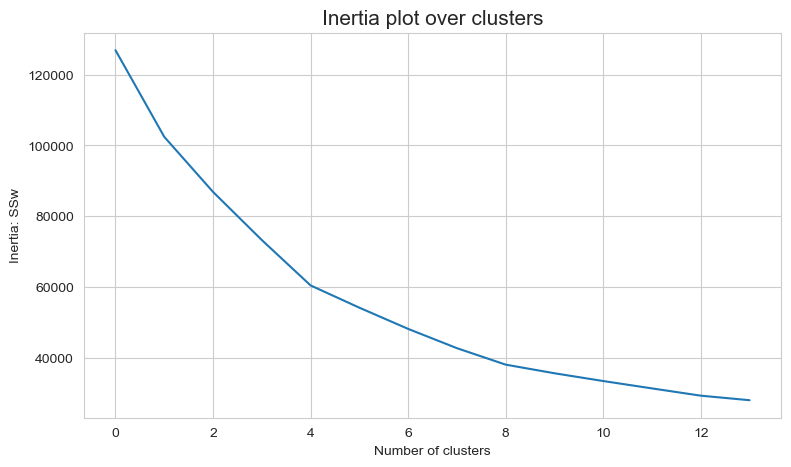

In [ ]:
#check  optimal number of clusters to keep with an elbow plot
range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_prf)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [ ]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_prf)

KMeans(n_clusters=4, n_init=15, random_state=15)

In [26]:
dist_matrix = pd.DataFrame(kmclust.transform(df_prf)) #calculates distance of each sample to respective centroid

In [27]:
km_labels = kmclust.predict(df_prf) #associates cluster index for each sample, based on min distance

In [ ]:
# Characterizing the final clusters
df_concat = pd.concat([df_prf, pd.Series(km_labels, name='prf_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('prf_labels').mean()
df_centroids

,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
prf_labels,,,,
0,0.023163,1.940639,0.154800,2.014428
1,2.736470,-0.069411,-0.150640,-0.065872
2,-0.220285,-0.173597,-0.154529,-0.172191
3,0.057290,0.385430,4.109293,0.172360


In [29]:
pd.DataFrame(km_labels)[0].value_counts() #not very well distributed between the 4 centroids

0
2    26405
0     2241
1     2086
3      985
Name: count, dtype: int64

In [30]:
df['prf_labels'] = df_concat['prf_labels'] # adds labels to scale df
df['prf_labels'].value_counts()

prf_labels
2    26405
0     2241
1     2086
3      985
Name: count, dtype: int64

In [31]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_prf) # get total sum of squares
ssw_labels = df_concat.groupby(['prf_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.422


### Behaviour/demographic Based Perspective

In [69]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_morning', 'HR_lunch',
       'HR_dinner', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders', 'avg_spendi

In [32]:
behaviour_features = [
    'Weekend',
    'Weekdays',
    'chain_order_ratio',
    'HR_breakfast',
    'HR_lunch_dinner',
    'HR_afternoon',
    'HR_evening'
]

df_beh = df[behaviour_features].copy()

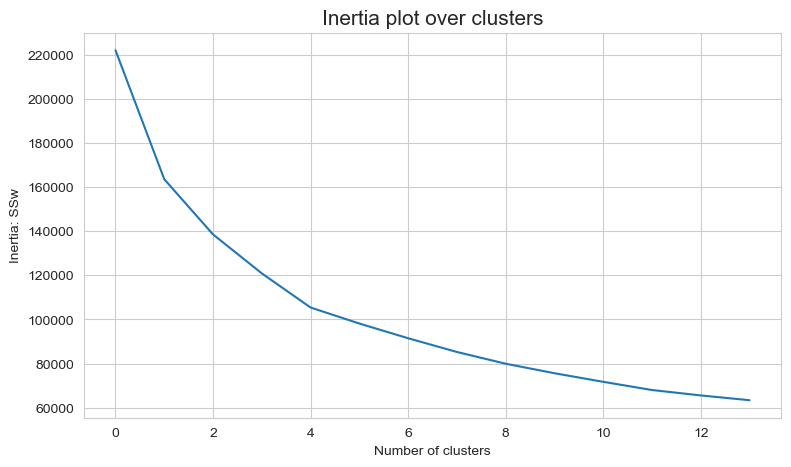

In [33]:
# check the optimal number of clusters to keep with an elbow plot
range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each ncluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_beh)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [ ]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_beh) #performs clustering ie finds centroids

KMeans(n_clusters=4, n_init=15, random_state=15)

In [35]:
dist_matrix = pd.DataFrame(kmclust.transform(df_beh)) #calculates distance of each sample to respective centroid

In [36]:
km_labels = kmclust.predict(df_beh) #associates cluster index for each sample, based on min distance

In [38]:
# Characterizing the final clusters
df_concat = pd.concat([df_beh, pd.Series(km_labels, name='beh_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('beh_labels').mean()

# Apply styling to the DataFrame
def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if m else '' for v, m in zip(is_max, is_min)]

df_styled = df_centroids.style.apply(highlight_max_min, axis=0)

# Display the styled DataFrame
df_styled


,Weekend,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening
beh_labels,,,,,,,
0,-0.181174,-0.210683,0.778482,-0.144523,-0.070364,-0.138241,-0.220739
1,-0.271989,-0.297531,-1.111196,-0.195772,-0.278079,-0.138055,-0.136105
2,2.270015,2.564154,0.167347,1.697718,2.124821,2.126221,-0.101389
3,0.639802,0.715974,-0.252609,0.513049,-0.174515,-0.452659,3.070399


In [39]:
pd.DataFrame(km_labels)[0].value_counts()

0
0    16379
1    11404
2     2179
3     1755
Name: count, dtype: int64

In [40]:
df['beh_labels'] = df_concat['beh_labels'] # adds labels to scale df
df['beh_labels'].value_counts()

beh_labels
0    16379
1    11404
2     2179
3     1755
Name: count, dtype: int64

**better distributed than preference features**

In [41]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_beh) # get total sum of squares
ssw_labels = df_concat.groupby(['beh_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.456


In [143]:
silhoutte_score = silhouette_score(df_beh, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.285


In [144]:
calinski_harabasz = calinski_harabasz_score(df_beh, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  8848.769


### Merging cluster Kmeans:

In [185]:
# Count label frequencies (contigency table)

pd.crosstab(df['value_labels'],
            df['prf_labels'])

prf_labels,0,1,2,3
value_labels,,,,
0,30,168,8385,66
1,341,1202,16631,354
2,1870,716,1389,565


In [186]:
to_merge = [(0,0), (0,3)]

In [187]:
# Get centroids of clusters
df_centroids = df.groupby(['value_labels', 'prf_labels'])\
    [preference_features + value_perspetive].mean()

df_centroids

Western_Cuisine  Asian_Cuisine  \
value_labels prf_labels                                   
0            0                 -0.309997       0.316957   
             1                  1.737928      -0.513584   
             2                 -0.270814      -0.313644   
             3                 -0.422753      -0.509613   
1            0                 -0.137061       0.707632   
             1                  2.092698      -0.336944   
             2                 -0.188362      -0.170505   
             3                 -0.229058      -0.236557   
2            0                  0.057725       2.191530   
             1                  4.051509       0.483936   
             2                 -0.297472       0.634804   
             3                  0.292776       0.879688   

                         Complementary_Cuisine  Other_Cuisines  total_spent  \
value_labels prf_labels                                                       
0            0                       -0.209389        2.029064     0.843544   
             1                       -0.244683       -0.361588     0.113599   
             2                       -0.202580       -0.239160    -0.459582   
             3                        2.752532       -0.411062     0.184084   
1            0                        0.027651        1.605671     1.056036   
             1                       -0.257895       -0.213551     0.416024   
             2                       -0.135881       -0.161483    -0.286031   
             3                        2.995673       -0.188405     0.594324   
2            0                        0.183829        2.088731     2.311825   
             1                        0.051483        0.251431     1.960850   
             2                       -0.087731        0.103876     0.304196   
             3                        4.965519        0.466548     2.360845   

                         avg_spending_per_order  last_order  
value_labels prf_labels                                      
0            0                         0.732029   -1.419743  
             1                         0.635928   -1.206359  
             2                         0.025783   -1.381705  
             3                         1.166868   -1.217121  
1            0                        -0.447614    0.788671  
             1                        -0.157586    0.628866  
             2                        -0.355925    0.500991  
             3                        -0.175268    0.666890  
2            0                         1.188858    0.585887  
             1                         0.568897    0.650946  
             2                         1.990741    0.281543  
             3                         0.895321    0.646969

In [188]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

value_labels                    0                                           1  \
prf_labels                      0             1         2         3         0   
value_labels prf_labels                                                         
0            0           0.000000  3.344824e+00  2.782525  4.011004  2.594569   
             1           3.344824  4.214685e-08  2.196211  3.733804  3.872159   
             2           2.782525  2.196211e+00  0.000000  3.250723  3.427686   
             3           4.011004  3.733804e+00  3.250723  0.000000  4.521675   
1            0           2.594569  3.872159e+00  3.427686  4.521675  0.000000   
             1           4.050085  2.065994e+00  3.230039  4.546937  3.158059   
             2           3.347405  2.817570e+00  1.938591  3.750596  2.411564   
             3           4.554323  4.344408e+00  3.948033  2.395808  3.637306   
2            0           3.192885  4.967745e+00  4.985688  5.305925  2.606492   
             1           5.276494  3.698327e+00  5.468910  5.978701  4.615153   
             2           2.931205  3.128680e+00  2.870878  3.549201  3.011271   
             3           6.041630  6.357194e+00  6.463387  4.049260  5.424074   

value_labels                                                  2            \
prf_labels                      1         2         3         0         1   
value_labels prf_labels                                                     
0            0           4.050085  3.347405  4.554323  3.192885  5.276494   
             1           2.065994  2.817570  4.344408  4.967745  3.698327   
             2           3.230039  1.938591  3.948033  4.985688  5.468910   
             3           4.546937  3.750596  2.395808  5.305925  5.978701   
1            0           3.158059  2.411564  3.637306  2.606492  4.615153   
             1           0.000000  2.407719  4.002564  4.630199  2.781629   
             2           2.407719  0.000000  3.263213  4.466304  4.953450   
             3           4.002564  3.263213  0.000000  4.887420  5.488670   
2            0           4.630199  4.466304  4.887420  0.000000  4.771912   
             1           2.781629  4.953450  5.488670  4.771912  0.000000   
             2           3.396376  2.576146  3.909095  3.365884  4.886733   
             3           6.112101  6.028763  3.177220  5.231111  6.224571   

value_labels                                 
prf_labels                      2         3  
value_labels prf_labels                      
0            0           2.931205  6.041630  
             1           3.128680  6.357194  
             2           2.870878  6.463387  
             3           3.549201  4.049260  
1            0           3.011271  5.424074  
             1           3.396376  6.112101  
             2           2.576146  6.028763  
             3           3.909095  3.177220  
2            0           3.365884  5.231111  
             1           4.886733  6.224571  
             2           0.000000  5.624813  
             3           5.624813  0.000000

In [189]:
# Merging each low frequency clustering (source) 
# to the closest cluster (target)

source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(0, 0): (1, 0), (0, 3): (1, 3)}

In [190]:
df_ = df.copy()

# Changing the value_labels and prf_labels based on source_target
for source, target in source_target.items():
    mask = (df_['value_labels']==source[0]) & (df_['prf_labels']==source[1])
    df_.loc[mask, 'value_labels'] = target[0]
    df_.loc[mask, 'prf_labels'] = target[1]

In [191]:
# New contigency table

pd.crosstab(df_['value_labels'],
            df_['prf_labels'])

prf_labels,0,1,2,3
value_labels,,,,
0,0,168,8385,0
1,371,1202,16631,420
2,1870,716,1389,565


In [192]:
# Original contigency table

pd.crosstab(df['value_labels'],
            df['prf_labels'])


prf_labels,0,1,2,3
value_labels,,,,
0,30,168,8385,66
1,341,1202,16631,354
2,1870,716,1389,565


### Merging using Hierarchical clustering

In [116]:
df.head()

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,0.429816,-0.209739,-0.4837,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,2,2,1
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,0.429816,-0.427887,-0.4837,-0.088755,0.963778,CUI_American,Western_Cuisine,2,2,0
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,0.429816,-0.653705,-0.4837,-0.727873,0.963778,CUI_American,Western_Cuisine,2,2,0
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,-0.148714,-0.149281,-0.4837,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,2,2,1
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,-0.148714,0.389434,-0.4837,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,1,2,1


In [196]:
metric_features = value_perspetive + behaviour_features + preference_features

In [197]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'prf_labels', 'beh_labels'])\
    [metric_features].mean()
df_centroids

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.793746                0.494837   
                        1              0.683452                1.046361   
                        2              2.024867               -0.552900   
                        3              1.059218                0.623788   
             1          0              0.081695                0.655572   
                        1              0.053369                0.712993   
                        2              1.051142               -0.454237   
                        3              0.464444                0.290682   
             2          0             -0.511351               -0.157875   
                        1             -0.397059                0.300718   
                        2              0.231704               -0.803320   
                        3              0.094661               -0.005999   
             3          0              0.115119                1.169812   
                        1              0.151461                1.728181   
                        2              1.248603               -0.448977   
                        3              0.353243                0.248526   
1            0          0              0.757832               -0.000390   
                        1              0.768407                0.033539   
                        2              1.169588               -0.646687   
                        3              0.992137               -0.186540   
             1          0              0.296554               -0.099642   
                        1              0.284403               -0.059601   
                        2              0.982953               -0.545725   
                        3              0.465269               -0.104315   
             2          0             -0.367248               -0.474990   
                        1             -0.287897               -0.113976   
                        2              0.398067               -0.789343   
                        3              0.214650               -0.222275   
             3          0              0.402354               -0.079182   
                        1              0.376198                0.185496   
                        2              1.008680               -0.634460   
                        3              0.698903               -0.097479   
2            0          0              1.556847                1.804735   
                        1              1.580172                2.142973   
                        2              3.267157               -0.086883   
                        3              2.772262                0.846289   
             1          0              1.025902                1.168769   
                        1              1.052664                1.294051   
                        2              2.862033               -0.156080   
                        3              1.955428                0.766508   
             2          0              0.274291                2.095929   
                        1              0.238518                2.090151   
                        2              1.411255               -0.194772   
                        3              0.950605                0.726503   
             3          0              1.082339                1.850499   
                        1              1.036659                1.958377   
                        2              3.745293               -0.170837   
                        3              2.640095                0.679071   

                                    last_order   Weekend  Weekdays  \
value_labels prf_labels beh_labels                                   
0            0          0            -1.398173  0.172692  0.310877   
                        1            -1.431426  0.140551 -0.130967   
     

In [198]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

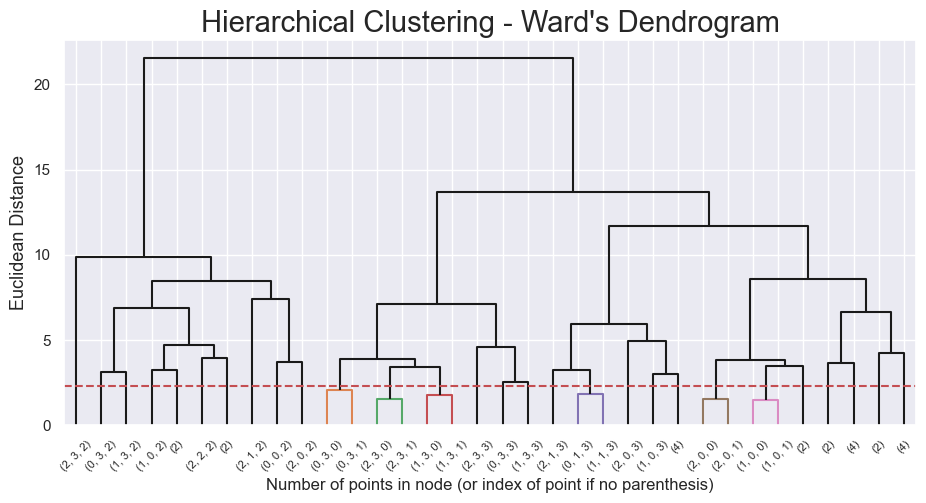

In [199]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 2.3
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

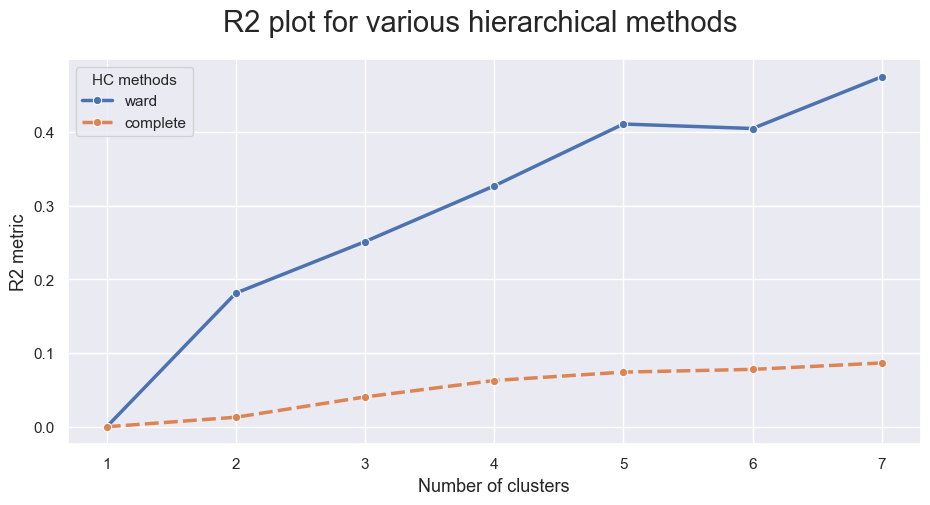

In [200]:
hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7)

In [220]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.793746                0.494837   
                        1              0.683452                1.046361   
                        2              2.024867               -0.552900   
                        3              1.059218                0.623788   
             1          0              0.081695                0.655572   
                        1              0.053369                0.712993   
                        2              1.051142               -0.454237   
                        3              0.464444                0.290682   
             2          0             -0.511351               -0.157875   
                        1             -0.397059                0.300718   
                        2              0.231704               -0.803320   
                        3              0.094661               -0.005999   
             3          0              0.115119                1.169812   
                        1              0.151461                1.728181   
                        2              1.248603               -0.448977   
                        3              0.353243                0.248526   
1            0          0              0.757832               -0.000390   
                        1              0.768407                0.033539   
                        2              1.169588               -0.646687   
                        3              0.992137               -0.186540   
             1          0              0.296554               -0.099642   
                        1              0.284403               -0.059601   
                        2              0.982953               -0.545725   
                        3              0.465269               -0.104315   
             2          0             -0.367248               -0.474990   
                        1             -0.287897               -0.113976   
                        2              0.398067               -0.789343   
                        3              0.214650               -0.222275   
             3          0              0.402354               -0.079182   
                        1              0.376198                0.185496   
                        2              1.008680               -0.634460   
                        3              0.698903               -0.097479   
2            0          0              1.556847                1.804735   
                        1              1.580172                2.142973   
                        2              3.267157               -0.086883   
                        3              2.772262                0.846289   
             1          0              1.025902                1.168769   
                        1              1.052664                1.294051   
                        2              2.862033               -0.156080   
                        3              1.955428                0.766508   
             2          0              0.274291                2.095929   
                        1              0.238518                2.090151   
                        2              1.411255               -0.194772   
                        3              0.950605                0.726503   
             3          0              1.082339                1.850499   
                        1              1.036659                1.958377   
                        2              3.745293               -0.170837   
                        3              2.640095                0.679071   

                                    last_order   Weekend  Weekdays  \
value_labels prf_labels beh_labels                                   
0            0          0            -1.398173  0.172692  0.310877   
                        1            -1.431426  0.140551 -0.130967   
     

In [221]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 5,
 (0, 0, 1): 5,
 (0, 0, 2): 0,
 (0, 0, 3): 3,
 (0, 1, 0): 6,
 (0, 1, 1): 6,
 (0, 1, 2): 2,
 (0, 1, 3): 3,
 (0, 2, 0): 6,
 (0, 2, 1): 6,
 (0, 2, 2): 2,
 (0, 2, 3): 3,
 (0, 3, 0): 1,
 (0, 3, 1): 1,
 (0, 3, 2): 2,
 (0, 3, 3): 1,
 (1, 0, 0): 5,
 (1, 0, 1): 5,
 (1, 0, 2): 2,
 (1, 0, 3): 3,
 (1, 1, 0): 6,
 (1, 1, 1): 6,
 (1, 1, 2): 2,
 (1, 1, 3): 3,
 (1, 2, 0): 6,
 (1, 2, 1): 6,
 (1, 2, 2): 2,
 (1, 2, 3): 3,
 (1, 3, 0): 1,
 (1, 3, 1): 1,
 (1, 3, 2): 2,
 (1, 3, 3): 1,
 (2, 0, 0): 5,
 (2, 0, 1): 5,
 (2, 0, 2): 0,
 (2, 0, 3): 3,
 (2, 1, 0): 6,
 (2, 1, 1): 6,
 (2, 1, 2): 0,
 (2, 1, 3): 3,
 (2, 2, 0): 6,
 (2, 2, 1): 6,
 (2, 2, 2): 2,
 (2, 2, 3): 3,
 (2, 3, 0): 1,
 (2, 3, 1): 1,
 (2, 3, 2): 4,
 (2, 3, 3): 1}

In [222]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['prf_labels'], row['beh_labels'])
    ], axis=1
)

df_hc

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,merged_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,-0.209739,-0.48370,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,0,2,1,6
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,-0.427887,-0.48370,-0.088755,0.963778,CUI_American,Western_Cuisine,0,2,0,6
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,-0.653705,-0.48370,-0.727873,0.963778,CUI_American,Western_Cuisine,0,2,0,6
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,-0.149281,-0.48370,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,0,2,1,6
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,0.389434,-0.48370,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,0,2,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712,8670,0.356477,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,FREEBIE,DIGI,-0.422050,...,-0.454282,-0.68905,0.988360,0.963778,CUI_Beverages,Complementary_Cuisine,0,2,0,6
31713,8670,-0.208171,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DELIVERY,DIGI,1.138191,...,-0.454282,-0.68905,0.988360,-1.619510,CUI_American,Western_Cuisine,0,2,1,6
31714,8670,-0.490496,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,-,DIGI,-0.422050,...,-0.459921,-0.68905,0.956436,0.963778,CUI_Desserts,Complementary_Cuisine,0,2,0,6
31715,8670,0.921125,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DISCOUNT,DIGI,-0.422050,...,-0.589863,-0.68905,0.220908,-1.619510,CUI_Asian,Asian_Cuisine,0,2,1,6


In [223]:
df_hc['merged_labels'].value_counts()

merged_labels
6    26301
3     1500
2     1277
5     1002
0      738
1      735
4      164
Name: count, dtype: int64

In [224]:
# Merged cluster centroids
df_hc.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,total_spent,avg_spending_per_order,last_order,Weekend,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
merged_labels,,,,,,,,,,,,,,
0,3.095812,-0.116837,0.872759,2.714149,3.157418,-0.213053,2.183220,2.062470,2.952385,-0.005418,2.592395,2.189128,0.377064,1.511011
1,1.163215,0.820455,0.417477,0.332214,0.476354,0.035908,0.783210,-0.132713,-0.324524,1.258903,-0.151411,0.193116,3.683128,-0.041916
2,0.673295,-0.712460,0.783310,1.856435,2.046540,0.389818,1.064852,2.173694,1.589076,-0.184223,0.387940,0.380696,0.306244,0.474225
3,1.347053,0.323941,0.548140,0.598747,0.646463,-0.272172,0.412261,-0.179163,-0.452121,2.997439,0.325943,1.564482,0.193799,0.431726
4,3.745293,-0.170837,0.910637,3.491794,3.924905,0.146858,4.440834,2.024849,2.591006,0.111738,1.068312,1.417485,6.460334,1.198689
5,1.483016,1.817335,0.342711,0.125540,0.186456,-0.447687,0.411395,0.011544,-0.023125,0.022507,-0.229072,0.975525,-0.098753,2.420029
6,-0.308743,-0.071703,-0.124185,-0.236282,-0.269721,0.017710,-0.201726,-0.162551,-0.140419,-0.198589,-0.103870,-0.220537,-0.175951,-0.188546


In [225]:
df_hc.head(1)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,merged_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.42205,...,-0.209739,-0.4837,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,0,2,1,6


### Cluster profiling with categorical features such as Age Category, Customer Region and payment method. 

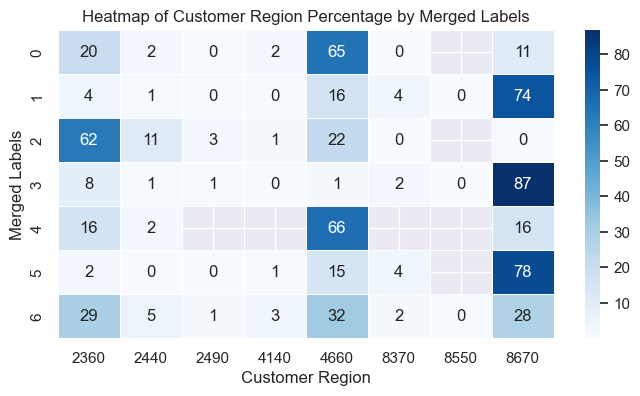

In [226]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()


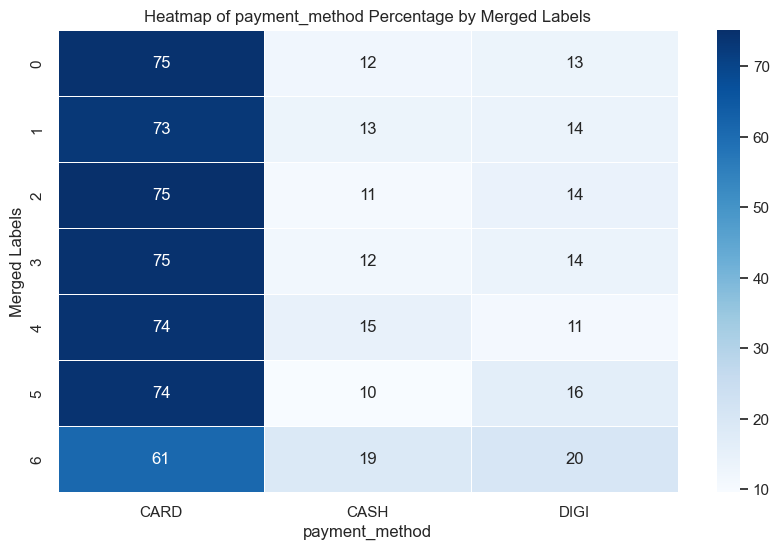

In [227]:
# Group by merged_labels and payment_method
df_cl_payment = df_hc.groupby(['merged_labels', 'payment_method'])['payment_method'].size().unstack()

# Calculate the percentage distribution
df_cl_payment_pct = df_cl_payment.copy()
for i in df_hc['payment_method'].unique():
    df_cl_payment_pct[i] = 100 * df_cl_payment_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_payment_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of payment_method Percentage by Merged Labels')
plt.xlabel('payment_method')
plt.ylabel('Merged Labels')
plt.show()

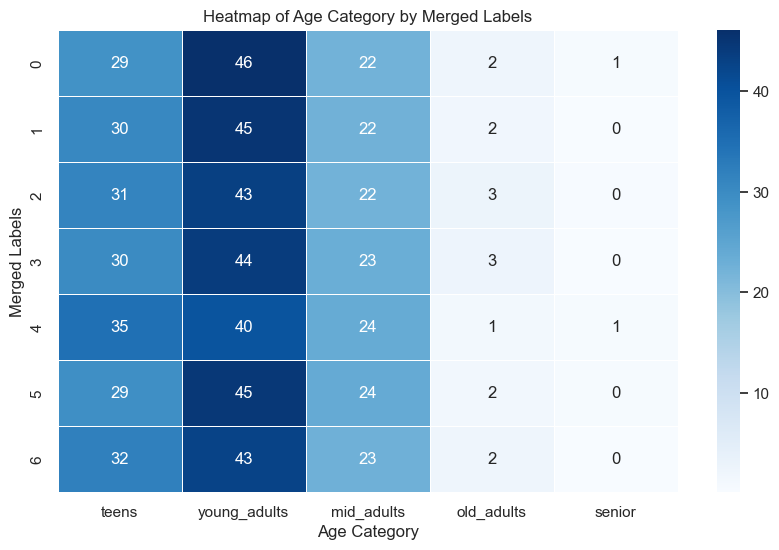

In [228]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()

In [211]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [ ]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

In [229]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.4257551006012146

In [230]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df_hc[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

total_spent               0.579485
avg_spending_per_order    0.150070
last_order                0.081463
Weekend                   0.439517
Weekdays                  0.566702
chain_order_ratio         0.017411
HR_breakfast              0.319877
HR_lunch_dinner           0.334257
HR_afternoon              0.367677
HR_evening                0.495790
Western_Cuisine           0.184495
Asian_Cuisine             0.314748
Complementary_Cuisine     0.565007
Other_Cuisines            0.292963
dtype: float64

In [231]:
# Preparing the data
X = df_hc[metric_features]
y = df_hc.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 89.44% of the customers correctly


In [232]:
pd.Series(dt.feature_importances_, index=X_train.columns).to_frame(name='Importance')

,Importance
total_spent,0.507955
avg_spending_per_order,0.000000
last_order,0.000000
Weekend,0.000000
Weekdays,0.090973
chain_order_ratio,0.000000
HR_breakfast,0.000000
HR_lunch_dinner,0.000000
HR_afternoon,0.000000
HR_evening,0.262092


### Cluster Analysis

In [216]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

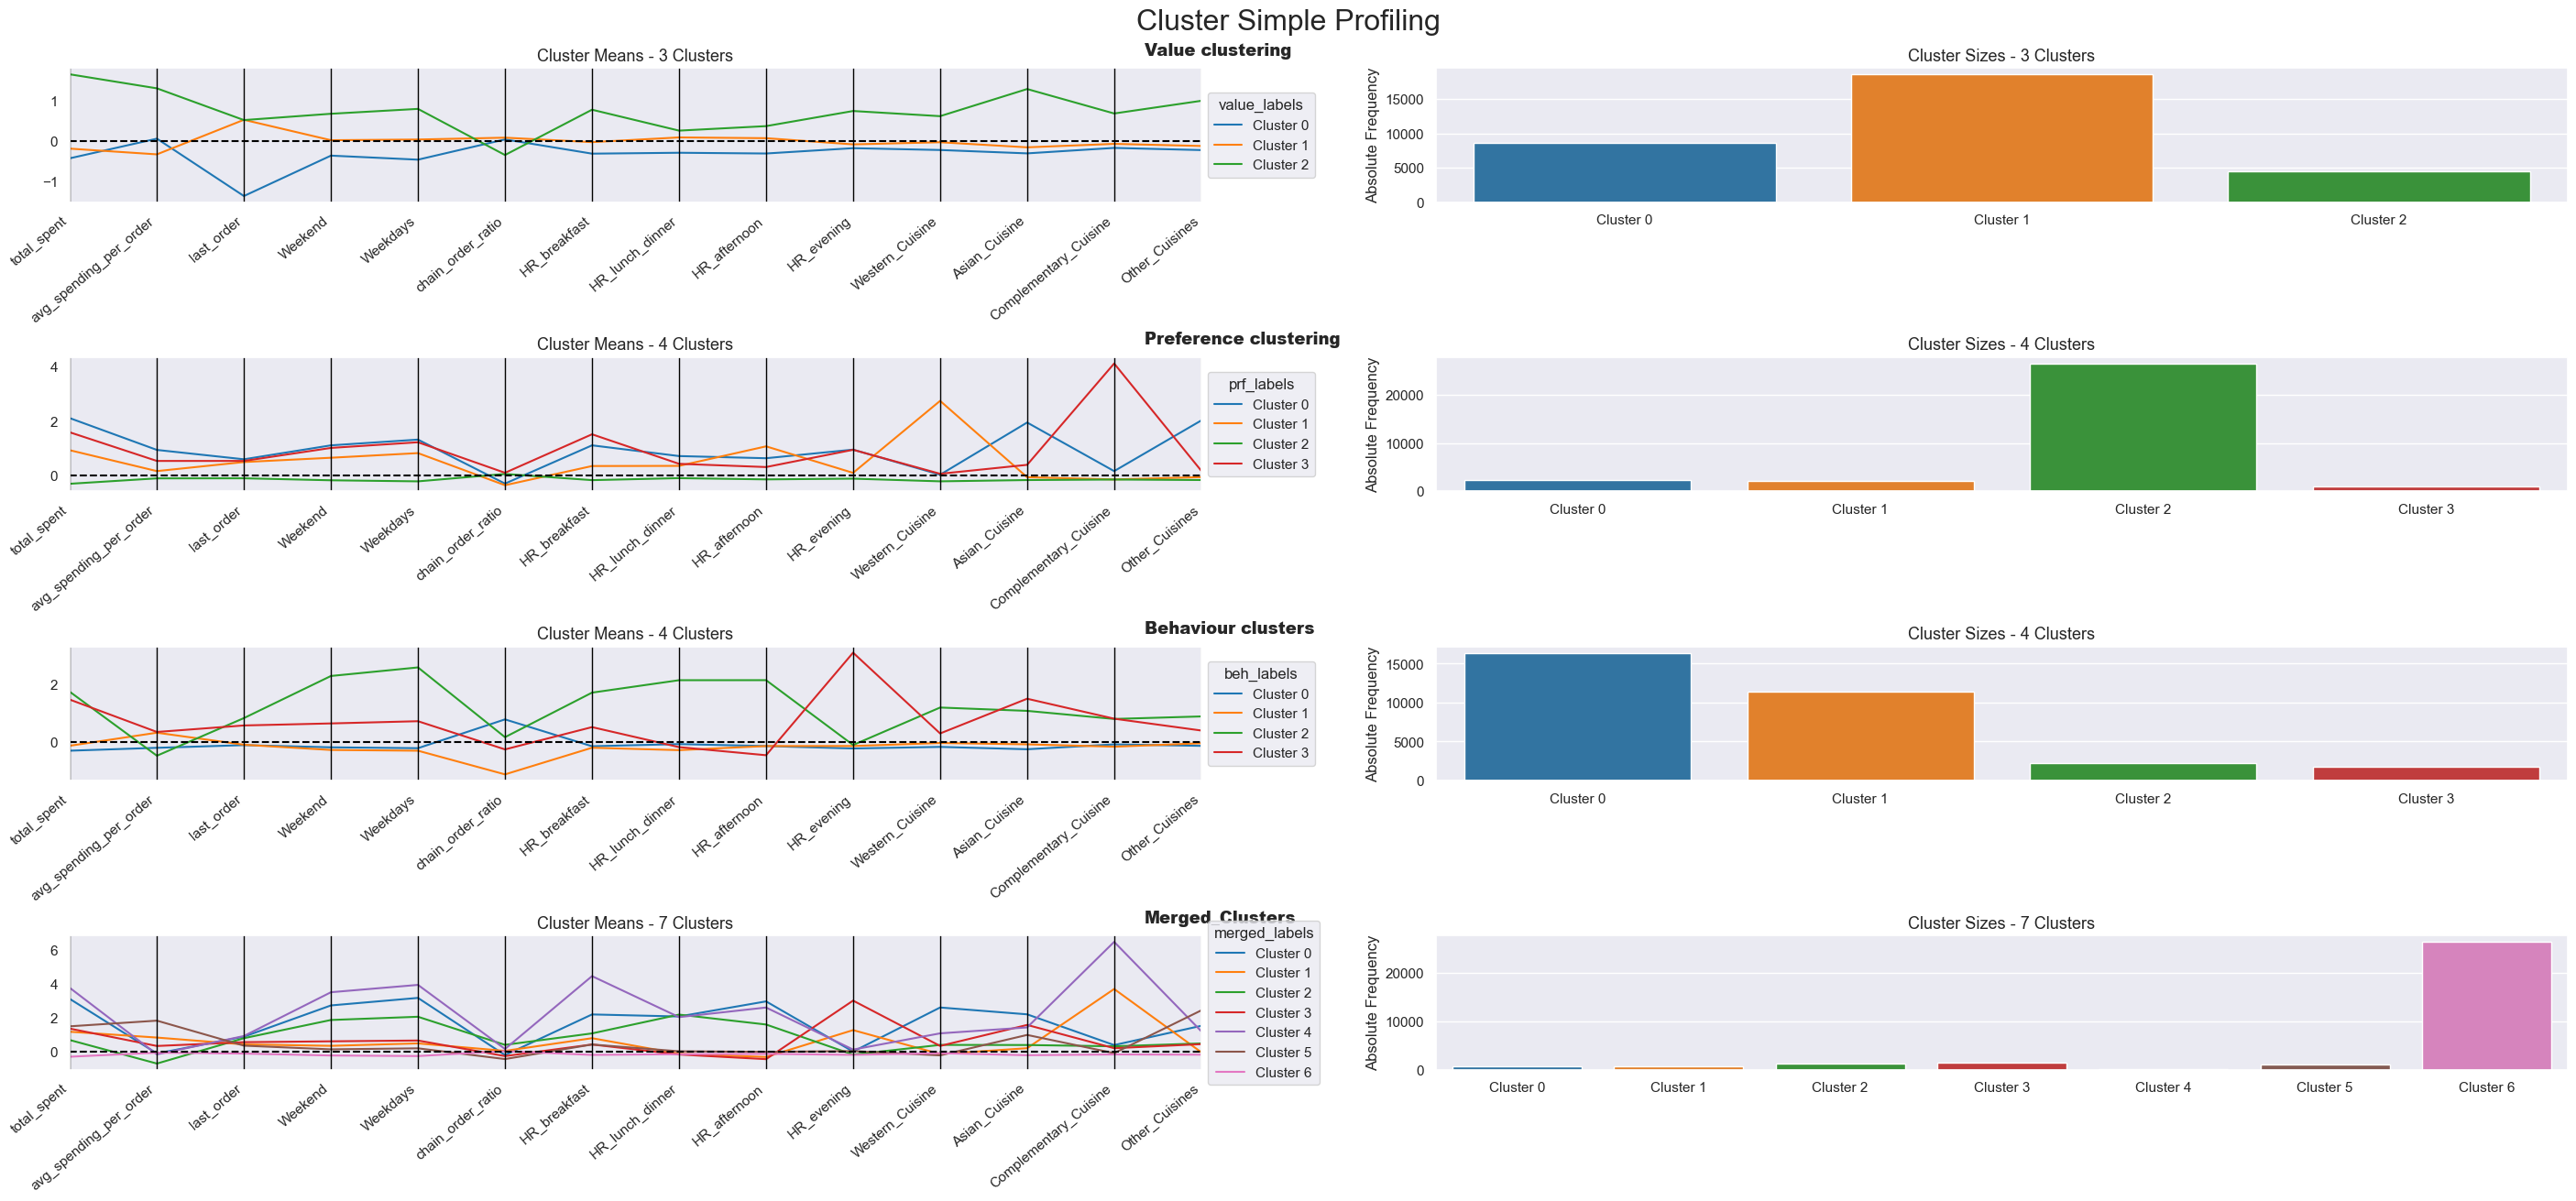

In [233]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_hc[metric_features + ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Preference clustering", "Behaviour clusters", "Merged_Clusters"]
)

### TSNE

In [234]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_hc[metric_features])

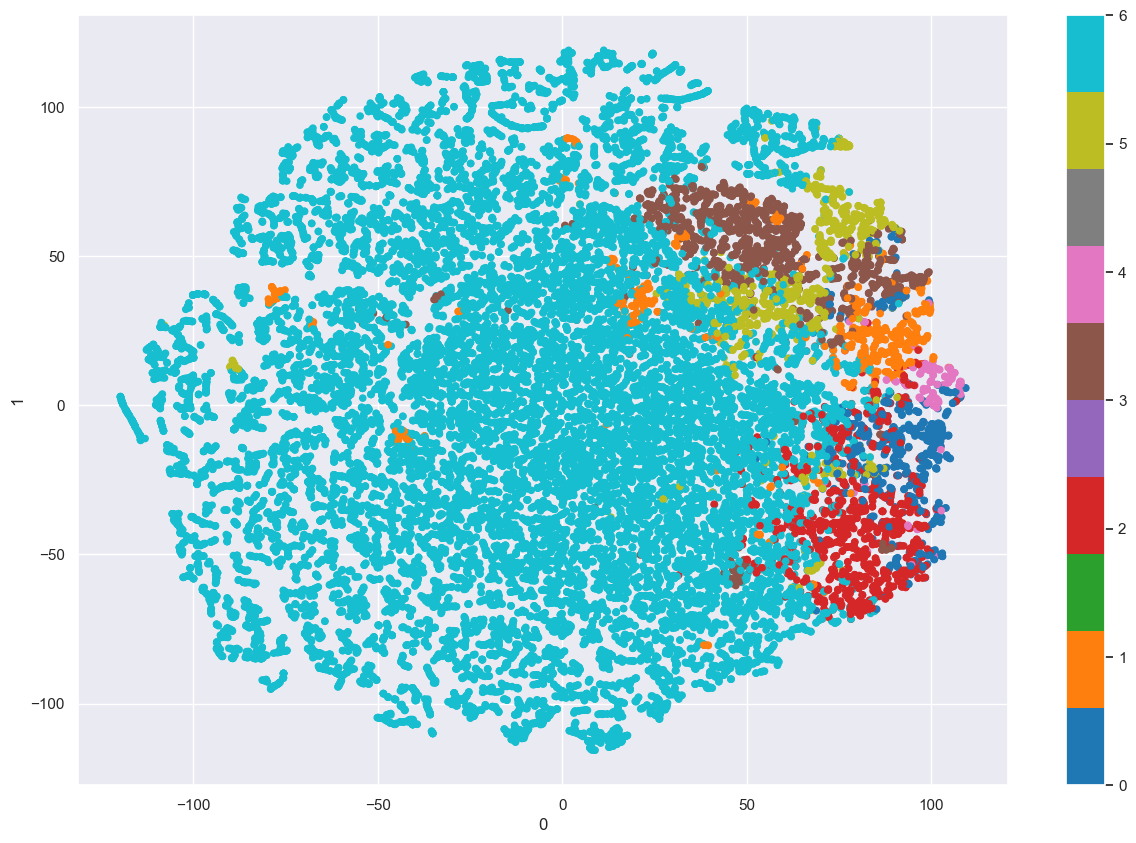

In [235]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_hc['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## 5.2.1 Value Features - Hierarchical Clustering

In [157]:
df_value_hc = df_value.copy()

In [158]:
df_value_hc.head()

,total_spent,avg_spending_per_order,last_order
0,-0.209739,0.528655,-2.706721
1,-0.427887,-0.088755,-2.706721
2,-0.653705,-0.727873,-2.706721
3,-0.149281,0.699767,-2.663582
4,0.389434,2.224456,-2.663582


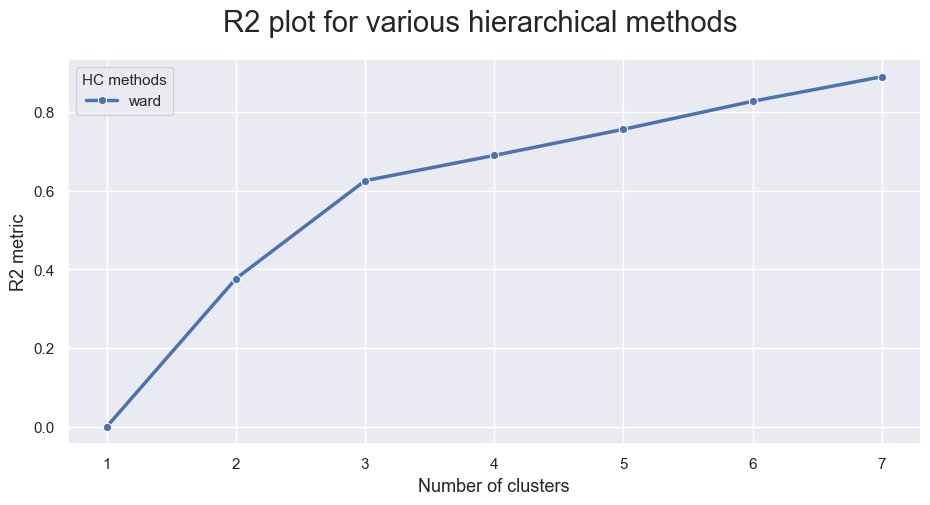

In [259]:
hierarchical_clustering_methods_nclust_analysis(df_value_hc, ["ward"], 7)

Optimal Number of Clusters = ?


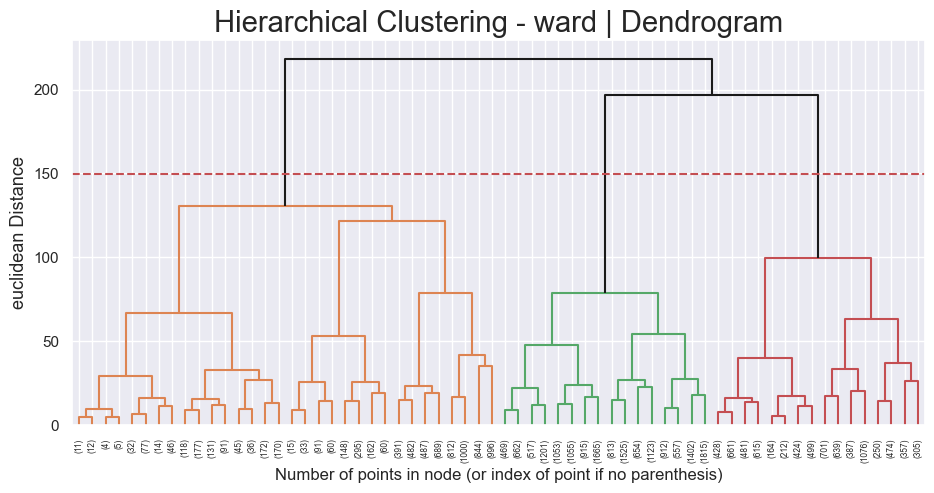

In [159]:
plot_dendrogram(dataframe=df_value_hc, y_threshold= 149.5, linkage="ward", metric='euclidean')

Optimal Number of Clusters = 4

In [165]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
df_value_hc['value_labels'] =  hclust.fit_predict(df_value_hc)
df_value_hc.groupby('value_labels').mean()

,total_spent,avg_spending_per_order,last_order
value_labels,,,
0,1.145841,0.781175,0.649982
1,-0.392649,0.232955,-1.427306
2,-0.356045,-0.477855,0.363750


## 5.2.2 Preference Based Features - Hierarchical Clustering


In [239]:
df_prf_hc = df_prf.copy()

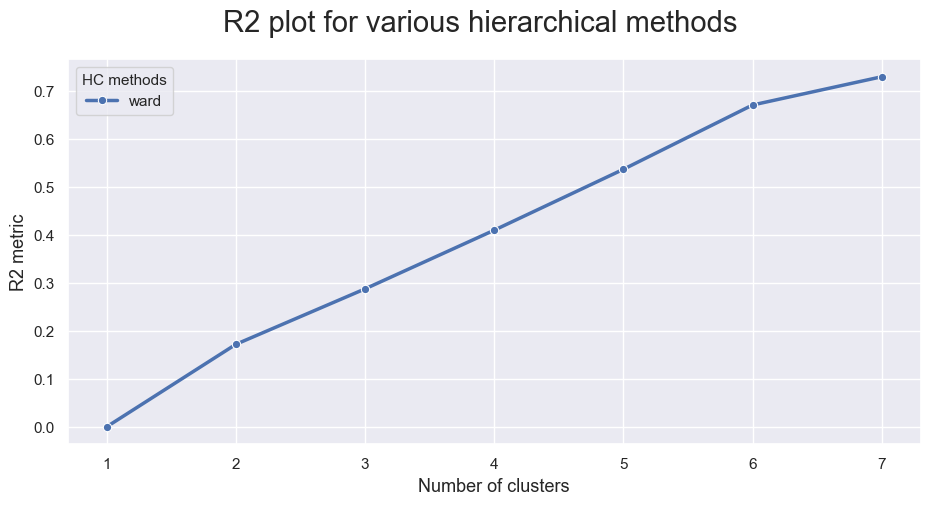

In [240]:
hierarchical_clustering_methods_nclust_analysis(df_prf_hc, ["ward"], 7)

In [241]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=6)
df_prf_hc['preference_labels'] =  hclust.fit_predict(df_prf_hc)
df_prf_hc.groupby('preference_labels').mean()

,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
preference_labels,,,,
0,0.063656,-0.094767,-0.097805,2.203125
1,-0.117570,3.039439,0.255158,0.194151
2,-0.110669,-0.166704,-0.333383,-0.254392
3,3.741621,0.214457,0.086950,-0.118735
4,0.260650,0.744747,7.817323,0.685651
5,-0.304036,-0.253879,0.915933,-0.192341


## 5.2.2 Behaviour Based Features - Hierarchical Clustering


In [236]:
df_beh_hc = df_beh.copy()

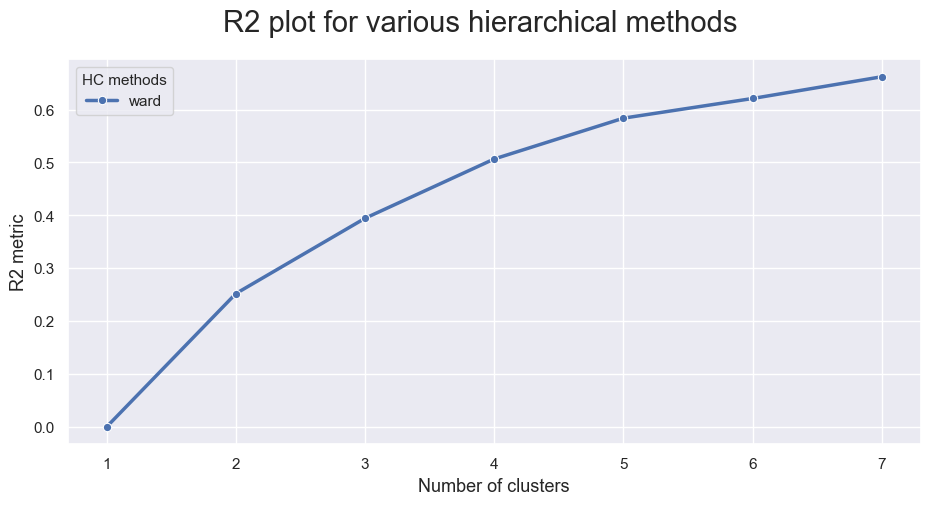

In [237]:
hierarchical_clustering_methods_nclust_analysis(df_beh_hc,["ward"], 7)

- The ward linkage is the one that performed better getting higher values in R^2 and the distance that will be used is euclidean

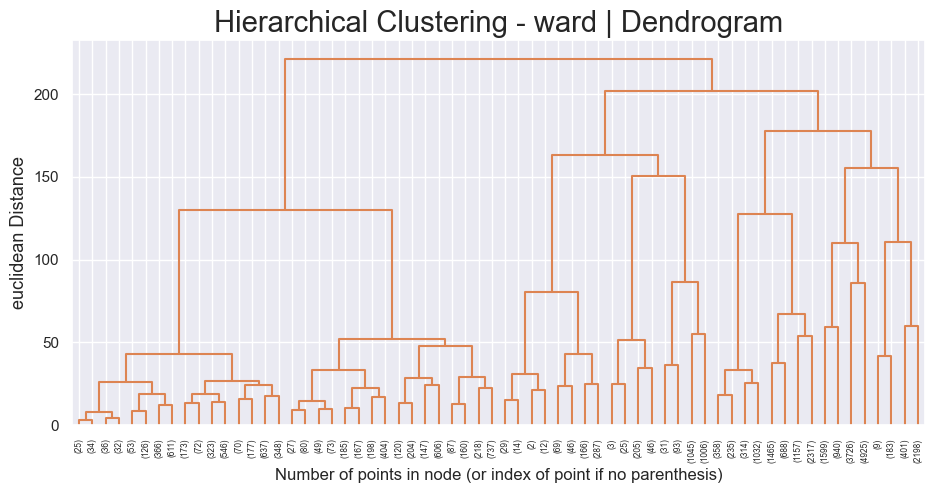

In [150]:
plot_dendrogram(dataframe=df_beh_hc, y_threshold=2400, linkage="ward", metric='euclidean')

In [238]:
hclust_beh = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
df_beh_hc['behaviour_labels'] =  hclust_beh.fit_predict(df_beh_hc)
df_beh_hc.groupby('behaviour_labels').mean()

,Weekend,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening
behaviour_labels,,,,,,,
0,2.187380,2.380259,0.242264,1.519566,2.026397,2.005555,-0.044054
1,0.024845,0.070764,-0.094170,0.108061,0.037785,0.118540,-0.221924
2,0.338060,0.393945,-0.281681,0.148173,-0.234100,-0.479738,2.533876
3,-0.448016,-0.535828,-1.619426,-0.375675,-0.390228,-0.334121,-0.194733
4,-0.403244,-0.471726,0.956927,-0.333510,-0.273557,-0.334503,-0.229759


## MERGED HC Perspetives

In [242]:
df["value_labels"] = df_value_hc["value_labels"]
df["preference_labels"] = df_prf_hc["preference_labels"]
df["behaviour_labels"] = df_beh_hc["behaviour_labels"]

In [243]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'prf_labels', 'beh_labels'])\
    [metric_features].mean()
df_centroids

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              1.501912                1.615843   
                        1              1.569385                2.026206   
                        2              2.561567               -0.276120   
                        3              2.698019                0.798040   
             1          0              0.763873                0.441009   
                        1              0.771979                0.520227   
                        2              2.244386               -0.277703   
                        3              1.634529                0.562846   
             2          0              0.182177                1.028896   
                        1              0.131269                1.236491   
                        2              0.834182               -0.626335   
                        3              0.715974                0.263143   
             3          0              0.938832                1.049378   
                        1              0.892113                1.448869   
                        2              3.041519               -0.279817   
                        3              2.242655                0.512839   
1            0          0              1.010915                1.522165   
                        1              0.723294                1.547162   
                        3              1.145350                1.045512   
             1          0              0.136065                0.873836   
                        1              0.119754                0.951070   
                        2              0.911286               -0.405544   
                        3              0.558729                0.578696   
             2          0             -0.491437               -0.019237   
                        1             -0.357538                0.468077   
                        2              0.260260               -0.769833   
                        3              0.222843                0.163491   
             3          0              0.191769                1.354452   
                        1              0.265086                1.774553   
                        2              1.248603               -0.448977   
                        3              0.468335                0.380751   
2            0          0              0.567588               -0.042115   
                        1              0.491101               -0.032238   
                        2              0.581037               -0.766341   
                        3              0.507532               -0.694181   
             1          0              0.106773               -0.189511   
                        1              0.073685               -0.151235   
                        2              0.433788               -0.750678   
                        3              0.104300               -0.317645   
             2          0             -0.427887               -0.574226   
                        1             -0.372870               -0.298715   
                        2              0.202009               -0.861448   
                        3             -0.030807               -0.395609   
             3          0              0.190557               -0.171134   
                        1              0.182058                0.017134   
                        2              0.526082               -0.821512   
                        3              0.160661               -0.258569   

                                    last_order   Weekend  Weekdays  \
value_labels prf_labels beh_labels                                   
0            0          0             0.476485  0.137390  0.294752   
                        1             0.441802  0.127568  0.151563   
                        2             0.878039  2.696982  3.185606   
          

In [244]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

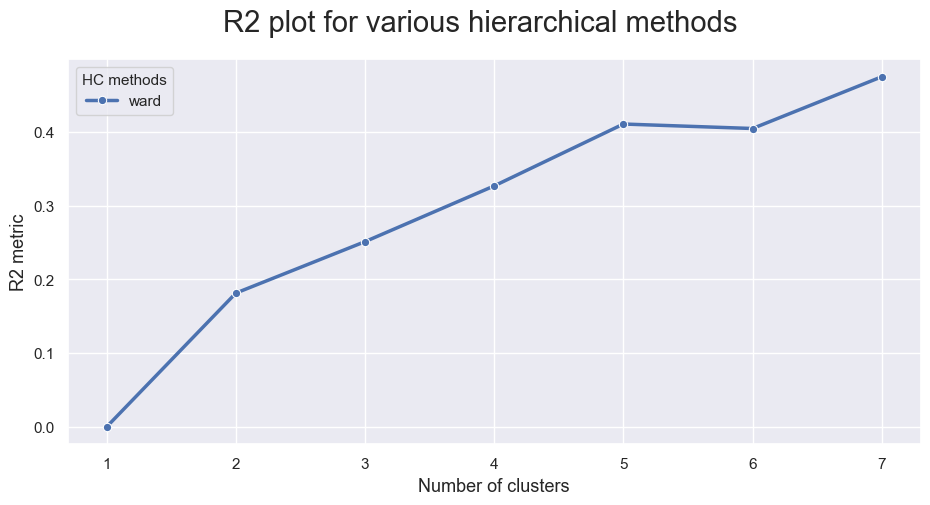

In [245]:
hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7)

In [246]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              1.501912                1.615843   
                        1              1.569385                2.026206   
                        2              2.561567               -0.276120   
                        3              2.698019                0.798040   
             1          0              0.763873                0.441009   
                        1              0.771979                0.520227   
                        2              2.244386               -0.277703   
                        3              1.634529                0.562846   
             2          0              0.182177                1.028896   
                        1              0.131269                1.236491   
                        2              0.834182               -0.626335   
                        3              0.715974                0.263143   
             3          0              0.938832                1.049378   
                        1              0.892113                1.448869   
                        2              3.041519               -0.279817   
                        3              2.242655                0.512839   
1            0          0              1.010915                1.522165   
                        1              0.723294                1.547162   
                        3              1.145350                1.045512   
             1          0              0.136065                0.873836   
                        1              0.119754                0.951070   
                        2              0.911286               -0.405544   
                        3              0.558729                0.578696   
             2          0             -0.491437               -0.019237   
                        1             -0.357538                0.468077   
                        2              0.260260               -0.769833   
                        3              0.222843                0.163491   
             3          0              0.191769                1.354452   
                        1              0.265086                1.774553   
                        2              1.248603               -0.448977   
                        3              0.468335                0.380751   
2            0          0              0.567588               -0.042115   
                        1              0.491101               -0.032238   
                        2              0.581037               -0.766341   
                        3              0.507532               -0.694181   
             1          0              0.106773               -0.189511   
                        1              0.073685               -0.151235   
                        2              0.433788               -0.750678   
                        3              0.104300               -0.317645   
             2          0             -0.427887               -0.574226   
                        1             -0.372870               -0.298715   
                        2              0.202009               -0.861448   
                        3             -0.030807               -0.395609   
             3          0              0.190557               -0.171134   
                        1              0.182058                0.017134   
                        2              0.526082               -0.821512   
                        3              0.160661               -0.258569   

                                    last_order   Weekend  Weekdays  \
value_labels prf_labels beh_labels                                   
0            0          0             0.476485  0.137390  0.294752   
                        1             0.441802  0.127568  0.151563   
                        2             0.878039  2.696982  3.185606   
          

In [247]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 4,
 (0, 0, 1): 4,
 (0, 0, 2): 5,
 (0, 0, 3): 3,
 (0, 1, 0): 1,
 (0, 1, 1): 1,
 (0, 1, 2): 5,
 (0, 1, 3): 3,
 (0, 2, 0): 1,
 (0, 2, 1): 1,
 (0, 2, 2): 6,
 (0, 2, 3): 3,
 (0, 3, 0): 0,
 (0, 3, 1): 0,
 (0, 3, 2): 2,
 (0, 3, 3): 0,
 (1, 0, 0): 4,
 (1, 0, 1): 4,
 (1, 0, 3): 3,
 (1, 1, 0): 1,
 (1, 1, 1): 1,
 (1, 1, 2): 6,
 (1, 1, 3): 3,
 (1, 2, 0): 1,
 (1, 2, 1): 1,
 (1, 2, 2): 6,
 (1, 2, 3): 3,
 (1, 3, 0): 0,
 (1, 3, 1): 0,
 (1, 3, 2): 2,
 (1, 3, 3): 0,
 (2, 0, 0): 4,
 (2, 0, 1): 4,
 (2, 0, 2): 6,
 (2, 0, 3): 4,
 (2, 1, 0): 1,
 (2, 1, 1): 1,
 (2, 1, 2): 6,
 (2, 1, 3): 3,
 (2, 2, 0): 1,
 (2, 2, 1): 1,
 (2, 2, 2): 6,
 (2, 2, 3): 3,
 (2, 3, 0): 0,
 (2, 3, 1): 0,
 (2, 3, 2): 2,
 (2, 3, 3): 0}

In [248]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['prf_labels'], row['beh_labels'])
    ], axis=1
)

df_hc

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,preference_labels,behaviour_labels,merged_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,1,2,1,2,1,1
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,-0.088755,0.963778,CUI_American,Western_Cuisine,1,2,0,2,1,1
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,-0.727873,0.963778,CUI_American,Western_Cuisine,1,2,0,2,1,1
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,1,2,1,2,1,1
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,1,2,1,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712,8670,0.356477,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,FREEBIE,DIGI,-0.422050,...,0.988360,0.963778,CUI_Beverages,Complementary_Cuisine,1,2,0,5,4,1
31713,8670,-0.208171,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DELIVERY,DIGI,1.138191,...,0.988360,-1.619510,CUI_American,Western_Cuisine,1,2,1,2,3,1
31714,8670,-0.490496,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,-,DIGI,-0.422050,...,0.956436,0.963778,CUI_Desserts,Complementary_Cuisine,1,2,0,5,4,1
31715,8670,0.921125,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DISCOUNT,DIGI,-0.422050,...,0.220908,-1.619510,CUI_Asian,Asian_Cuisine,1,2,1,2,3,1


In [249]:
df_hc['merged_labels'].value_counts()

merged_labels
1    26301
3     1498
5     1125
4     1004
6      804
0      735
2      250
Name: count, dtype: int64

In [250]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.3954058657671351

In [253]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

2605.326091263038

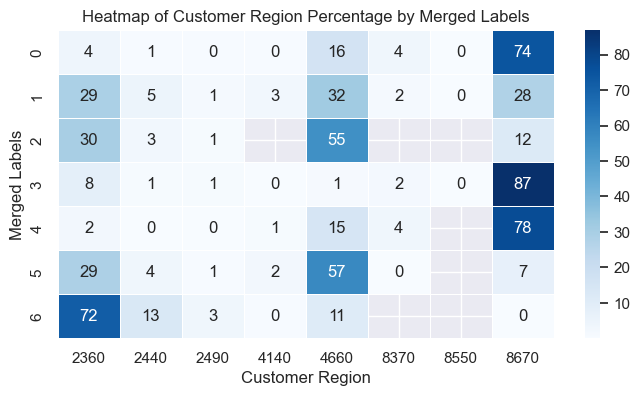

In [251]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()

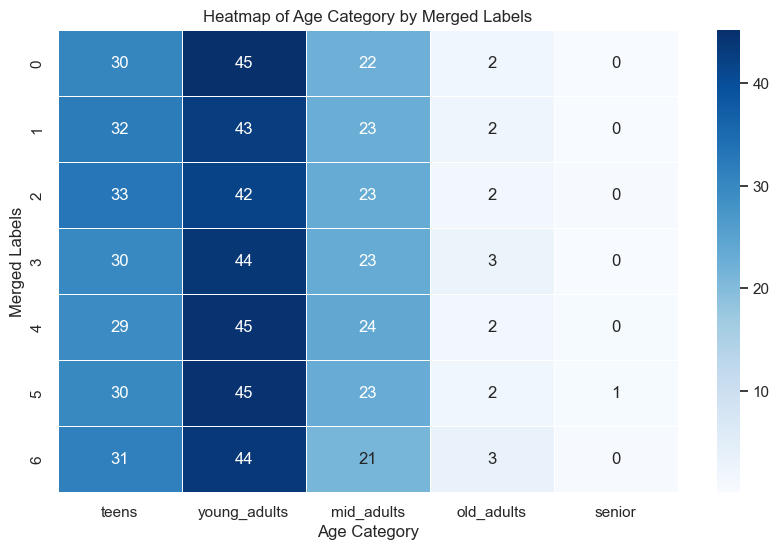

In [252]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()